## Predicting Heart Failure

In [6]:
import pandas as pd
import numpy as np
pd.set_option("display.max_colwidth", 200)

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OrdinalEncoder, 
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale,
)

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
heart_df = pd.read_csv('data/heart.csv')
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [38]:
train_df, test_df = train_test_split(heart_df, test_size=0.2, random_state=2021)

In [44]:
categorical_feat = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numeric_feat = list(set(heart_df.loc[:,heart_df.columns != 'HeartDisease'].columns)-set(categorical_feat))

In [43]:
X_train, y_train = train_df.drop(columns=['HeartDisease']), train_df['HeartDisease']
X_test, y_test = test_df.drop(columns=['HeartDisease']), test_df['HeartDisease']

In [45]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)


categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_feat),
        ("cat", categorical_transformer, categorical_feat),
    ], 
    #remainder='passthrough'    
)

In [46]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Cholesterol', 'Oldpeak', 'MaxHR',
                                  'RestingBP', 'Age', 'FastingBS']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'ChestPainType', 'RestingECG',
                                  'ExerciseAngina', 'ST_Slope'])])

In [47]:
X_train_pp = preprocessor.transform(X_train)

In [48]:
preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names(categorical_feat)

array(['Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N',
       'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat',
       'ST_Slope_Up'], dtype=object)

In [54]:
pipe_svc = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("svm", SVC()),
    ]
)

In [50]:
def store_cross_val_results(model_name, scores, results_dict):
    """
    Stores mean scores from cross_validate in results_dict for
    the given model model_name.

    Parameters
    ----------
    model_name :
        scikit-learn classification model
    scores : dict
        object return by `cross_validate`
    results_dict: dict
        dictionary to store results

    Returns
    ----------
        None

    """
    results_dict[model_name] = {
        "mean_train_score": "{:0.4f}".format(np.mean(scores["train_score"])),
        "mean_validation_score": "{:0.4f}".format(np.mean(scores["test_score"])),
        "mean_fit_time (s)": "{:0.4f}".format(np.mean(scores["fit_time"])),
        "mean_score_time (s)": "{:0.4f}".format(np.mean(scores["score_time"])),
        "std_train_score": "{:0.4f}".format(scores["train_score"].std()),
        "std_validation_score": "{:0.4f}".format(scores["test_score"].std()),
    }

In [55]:
results_dict = {}
scores = cross_validate(pipe_svc, X_train, y_train, return_train_score=True)
store_cross_val_results("imp + scaling + ohe + svm", scores, results_dict)
pd.DataFrame(results_dict).T

,mean_fit_time (s),mean_score_time (s),mean_train_score,mean_validation_score,std_train_score,std_validation_score
imp + scaling + ohe + svm,0.0200,0.0066,0.9074,0.8693,0.0044,0.0360


In [56]:
pipe_dtree = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("dtree", DecisionTreeClassifier()),
    ]
)

In [57]:
scores = cross_validate(pipe_dtree, X_train, y_train, return_train_score=True)
store_cross_val_results("imp + scaling + ohe + dtree", scores, results_dict)
pd.DataFrame(results_dict).T

,mean_train_score,mean_validation_score,mean_fit_time (s),mean_score_time (s),std_train_score,std_validation_score
imp + scaling + ohe + svm,0.9074,0.8693,0.0200,0.0066,0.0044,0.0360
imp + scaling + ohe + dtree,1.0000,0.7929,0.0144,0.0050,0.0000,0.0228


In [59]:
pipe_knn = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("knn", KNeighborsClassifier()),
    ]
)

In [60]:
scores = cross_validate(pipe_knn, X_train, y_train, return_train_score=True)
store_cross_val_results("imp + scaling + ohe + knn", scores, results_dict)
pd.DataFrame(results_dict).T

,mean_train_score,mean_validation_score,mean_fit_time (s),mean_score_time (s),std_train_score,std_validation_score
imp + scaling + ohe + svm,0.9074,0.8693,0.0200,0.0066,0.0044,0.0360
imp + scaling + ohe + dtree,1.0000,0.7929,0.0144,0.0050,0.0000,0.0228
imp + scaling + ohe + knn,0.8862,0.8570,0.0128,0.0124,0.0117,0.0343


## Hyperparameter Optimization

In [64]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "svm__gamma": 10.0 ** np.arange(-6, 6),
    "svm__C": 10.0 ** np.arange(-6, 6)
}
print("Grid size: %d" %(np.prod(list(map(len, param_grid.values())))))
param_grid

Grid size: 144


{'svm__gamma': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
        1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 'svm__C': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
        1.e+02, 1.e+03, 1.e+04, 1.e+05])}

In [65]:
random_search = RandomizedSearchCV(pipe_svc, param_distributions=param_grid, n_jobs=-1, n_iter=900, cv=5);
random_search.fit(X_train, y_train);

C:\Users\Jan\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 144 is smaller than n_iter=900. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [66]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svm__gamma",
        "param_svm__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().head(5)

,mean_test_score,param_svm__gamma,param_svm__C,mean_fit_time
rank_test_score,,,,
1,0.869276,0.01,10,0.034602
2,0.869267,0.001,1000,0.045598
2,0.869267,0.0001,100000,0.110995
4,0.866546,0.1,1,0.033000
5,0.863796,0.0001,1000,0.035399


In [67]:
random_search.score(X_test, y_test)

0.8858695652173914

## Better Metrics

In [68]:
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
)

import IPython

from IPython.display import HTML, display


%matplotlib inline

pd.set_option("display.max_colwidth", 200)

In [73]:
print(random_search.best_estimator_.named_steps['svm'].classes_)

[0 1]


In [77]:
best_svc = random_search.best_estimator_

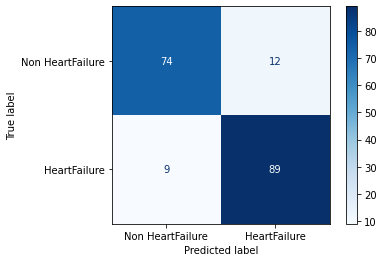

In [78]:
best_svc.fit(X_train, y_train)
plot_confusion_matrix(best_svc, X_test, y_test, display_labels=["Non HeartFailure", "HeartFailure"], values_format="d", cmap=plt.cm.Blues);

In [96]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

data = {}
data["accuracy"] = accuracy_score(y_test, best_svc.predict(X_test))
data["error"] = 1 - accuracy_score(y_test, best_svc.predict(X_test))
data["precision"]=precision_score(y_test, best_svc.predict(X_test), zero_division=1)
data["recall"]= recall_score(y_test, best_svc.predict(X_test))
data["f1 score"] = f1_score(y_test, best_svc.predict(X_test))
df = pd.DataFrame(data.items(), columns = ['metric', 'score'])
print(df)

      metric     score
0   accuracy  0.885870
1      error  0.114130
2  precision  0.881188
3     recall  0.908163
4   f1 score  0.894472
